In [68]:
from IPython.core.display import Image as IPyImage
from IPython.core.display import display

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import h5py
import cv2
from tqdm.notebook import tqdm

import PIL
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv2d, ELU, Flatten, Linear
from torch.optim import Adam

import torchvision as tv
from torchvision import transforms


from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
plt.style.use("dark_background")

In [69]:
DATA_DIR = "data"
TRAIN_VIDEO = os.path.join(DATA_DIR, "train.mp4")
TEST_VIDEO = os.path.join(DATA_DIR,"test.mp4")

CLEAN_DATA_DIR = "clean_data"
CLEAN_TRAIN_IMGS = os.path.join(CLEAN_DATA_DIR,"train_imgs")
CLEAN_TEST_IMGS = os.path.join(CLEAN_DATA_DIR,"test_imgs")

ASSETS_DIR = "assets"

seed = 503

In [70]:
train_meta = pd.read_csv("clean_data/train_meta.csv")
print("shape of train_meta:",train_meta.shape)
train_meta.head()

shape of train_meta: (20400, 3)


,img_path,img_index,speed
0,clean_data\train_imgs\frame0.jpg,0,28.105569
1,clean_data\train_imgs\frame1.jpg,1,28.105569
2,clean_data\train_imgs\frame2.jpg,2,28.106527
3,clean_data\train_imgs\frame3.jpg,3,28.130404
4,clean_data\train_imgs\frame4.jpg,4,28.109243


In [71]:
train_meta.loc[train_meta.index[1:],"img_path"]

1            clean_data\train_imgs\frame1.jpg
2            clean_data\train_imgs\frame2.jpg
3            clean_data\train_imgs\frame3.jpg
4            clean_data\train_imgs\frame4.jpg
5            clean_data\train_imgs\frame5.jpg
                         ...                 
20395    clean_data\train_imgs\frame20395.jpg
20396    clean_data\train_imgs\frame20396.jpg
20397    clean_data\train_imgs\frame20397.jpg
20398    clean_data\train_imgs\frame20398.jpg
20399    clean_data\train_imgs\frame20399.jpg
Name: img_path, Length: 20399, dtype: object

## split train and validation data

In [72]:
def meta_formatter(meta_df):
    """
    format df s.t
        [img_path, img_index, speed] -> [first_img_path,second_img_path,first_img_index,second_img_index,first_speed,second_speed]
    
    will return df with shape of (df.shape[0]-1, 6)
    """
    
    # rename the inital column names
    meta_df.rename(columns={
        "img_path":"first_img_path",
        "img_index":"first_img_index",
        "speed":"first_speed"}, inplace=True)
    
    # get the second image information
    second_path = meta_df["first_img_path"][1:].values
    second_index = meta_df["first_img_index"][1:].values
    second_speed = meta_df["first_speed"][1:].values
    
    # drop the last row of the input df
    meta_df.drop(meta_df.tail(1).index, inplace=True)
    
    # add second info
    meta_df["second_img_path"] = second_path
    meta_df["second_img_index"] = second_index
    meta_df["second_speed"] = second_speed
    
    # get the avg data between first and second speed
    meta_df["avg_speed"] = abs( (meta_df["first_speed"] + meta_df["second_speed"]) ) /2    
    # remove first and second speed
    #meta_df.drop(columns=["first_speed","second_speed"], inplace=True)
    
    return meta_df

In [73]:
train_meta = meta_formatter(train_meta)
train_meta.head()

,first_img_path,first_img_index,first_speed,second_img_path,second_img_index,second_speed,avg_speed
0,clean_data\train_imgs\frame0.jpg,0,28.105569,clean_data\train_imgs\frame1.jpg,1,28.105569,28.105569
1,clean_data\train_imgs\frame1.jpg,1,28.105569,clean_data\train_imgs\frame2.jpg,2,28.106527,28.106048
2,clean_data\train_imgs\frame2.jpg,2,28.106527,clean_data\train_imgs\frame3.jpg,3,28.130404,28.118465
3,clean_data\train_imgs\frame3.jpg,3,28.130404,clean_data\train_imgs\frame4.jpg,4,28.109243,28.119823
4,clean_data\train_imgs\frame4.jpg,4,28.109243,clean_data\train_imgs\frame5.jpg,5,28.088572,28.098907


In [74]:
train_df, val_df = train_test_split(train_meta, train_size= 0.75, random_state=seed)

train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(train_df.shape, val_df.shape)
train_df.head()

(15299, 7) (5100, 7)


,first_img_path,first_img_index,first_speed,second_img_path,second_img_index,second_speed,avg_speed
0,clean_data\train_imgs\frame7755.jpg,7755,24.653383,clean_data\train_imgs\frame7756.jpg,7756,24.661064,24.657224
1,clean_data\train_imgs\frame15776.jpg,15776,0.485482,clean_data\train_imgs\frame15777.jpg,15777,0.487062,0.486272
2,clean_data\train_imgs\frame19153.jpg,19153,9.724499,clean_data\train_imgs\frame19154.jpg,19154,9.680809,9.702654
3,clean_data\train_imgs\frame4094.jpg,4094,21.229045,clean_data\train_imgs\frame4095.jpg,4095,21.215251,21.222148
4,clean_data\train_imgs\frame16599.jpg,16599,2.258273,clean_data\train_imgs\frame16600.jpg,16600,2.271131,2.264702


### Plot train and validation distribution within the train_meta

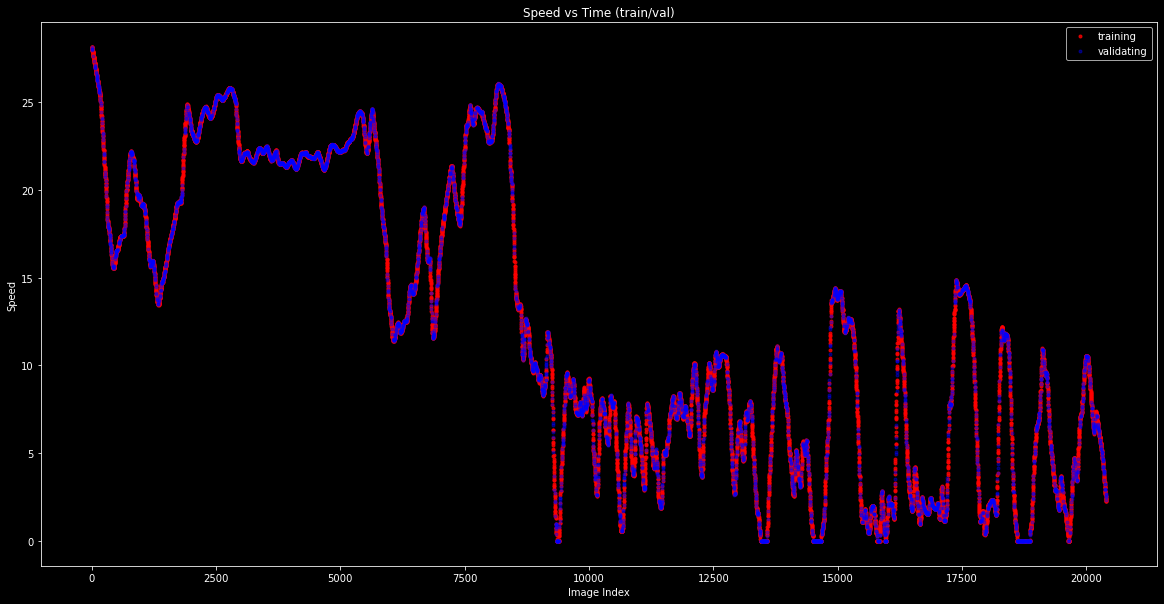

***************

training set shape:  (15299, 7)
validation set shape:  (5100, 7)


In [75]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_df.sort_values("first_img_index")[["first_img_index"]], train_df.sort_values("first_img_index")[["first_speed"]],"r.",alpha=0.8)
plt.plot(val_df.sort_values("first_img_index")[["first_img_index"]], val_df.sort_values("first_img_index")[["first_speed"]],"b.", alpha=0.4)
plt.xlabel("Image Index")
plt.ylabel("Speed")
plt.title("Speed vs Time (train/val)")
plt.legend(["training","validating"], loc="upper right")
plt.show()
plt.close()
print("***************\n")
print("training set shape: ",train_df.shape)
print("validation set shape: ",val_df.shape)

In [76]:
def brightness_augmentation(image, factor):
    """
    augements brigtness of the image by multiplying the saturation by a uniform random variable
    return: image with brightness augmentation
    """
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:,:,2] = hsv[:,:,2] * factor
    rgb = cv2.cvtColor(np.array(hsv,dtype=np.uint8), cv2.COLOR_HSV2RGB)
    return rgb

original image shape: (480, 640, 3)


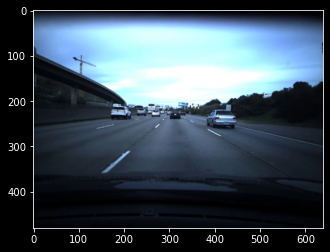

bright_factor: 1.005144455379996
brightned image


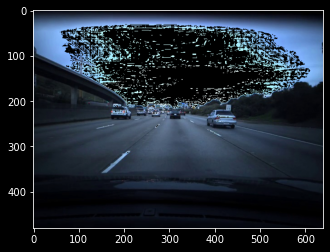

In [77]:
img=mpimg.imread(train_meta['first_img_path'][60])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

bright_factor = 0.7 + np.random.uniform()
print('bright_factor:', bright_factor)
print('brightned image')
img=mpimg.imread(train_meta['first_img_path'][60])
plt.imshow(brightness_augmentation(img, bright_factor))
plt.show()
plt.close()

In [93]:
def opticalFlowDense(curr_img, next_img):
    """
    input: curr_img, next_img (RGB images)
    
    Calculates optical flow magnitude and angle and place it into HSV image
    
    - Set the saturation to the saturation value of next_img
    - Set the hue to the angles returned from computing the flow params
    - Set the value to the magnitude returned from computing the flow params
    - Convert from HSV to RGB and return RGB image with same size as the original image
    """
    gray_curr = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(next_img, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(shape=(66, 220, 3))
    #set saturation
    hsv[:,:,1] = cv2.cvtColor(next_img, cv2.COLOR_RGB2HSV)[:,:,1]

    # FlowParams
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0
    
    # obtain dense optical flow params
    flow = cv2.calcOpticalFlowFarneback(gray_curr, gray_next,
                                       flow_mat,
                                       image_scale,
                                       nb_images,
                                       win_size,
                                       nb_iterations,
                                       deg_expansion,
                                       STD,
                                       extra)
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[...,0],flow[...,1])
    
    #hue corresponds to direction
    hsv[:,:,0] = ang*(180 / np.pi / 2)
    
    # value corresponds to mag
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # convert hsv to float32
    hsv = np.asarray(hsv, dtype=np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb_flow

In [94]:
def preprocess_image(image):
    """
    preprocesses the image: trim top and bottom and resize the image to (220,66,3)
    
    input: image (480,640,3) rgb 
    output: image( 220,66,3) rgb
    
    1. crop out black spots
    2. resize to 220,66,3 if not done from perspective transform
    """
    image_cropped = image[35:375, :] #v1 for data
    image = cv2.resize(image_cropped,(220,66), interpolation=cv2.INTER_AREA)
    return image

original image shape: (480, 640, 3)


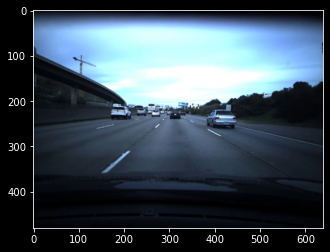

post prosessed image: (66, 220, 3)


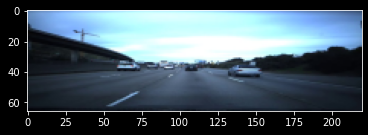

In [95]:
mg=mpimg.imread(train_meta['first_img_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [96]:
def preprocess_img_valid_from_path(img_path,speed):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed
def preprocess_img_from_path(img_path, speed, bright_factor):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = brightness_augmentation(img,bright_factor)
    img = preprocess_image(img)
    return img, speed

In [97]:
def generate_training_data(data,input_size,batch_size = 8):
    image_batch = np.zeros((batch_size, 66,220,3))
    label_batch = np.zeros((batch_size))
    
    while True:
        for i in range(batch_size):
            # get a random index 
            idx = np.random.randint(len(data)-1)
            brighting_factor = 0.2 + np.random.uniform()
            
            row1 = data.iloc[[idx]]
            row2 = data.iloc[[idx + 1]]
            
            # preprocess and get speed data
            x1,y1 = preprocess_img_from_path(row1["img_path"].values[0], row1["speed"].values[0], brighting_factor)
            x2,y2 = preprocess_img_from_path(row2["img_path"].values[0], row2["speed"].values[0], brighting_factor)
            
            # get the flow from two frames
            flow = opticalFlowDense(x1,x2)
            
            # get the avg speed between two frames
            y = np.mean([y1,y2])
            
            image_batch[i] = flow
            label_batch[i] = y
            
        yield skl.utils.shuffle(image_batch, label_batch)

In [98]:
def generate_val_data(data):
    while True:
        for i in range(len(data)-1):
            row1 = data.iloc[[i]]
            row2 = data.iloc[[i+1]]
            
            x1,y1 = preprocess_img_valid_from_path(row1["img_path"].values[0],row1["speed"].values[0])
            x2,y2 = preprocess_img_valid_from_path(row2["img_path"].values[0],row2["speed"].values[0])
            
            flow = opticalFlowDense(x1,x2)
            
            # reshape so that it matches the shape as training
            flow = flow.reshape(1, flow,shape[0], flow.shape[1], flow.shape[2])
            
            y = np.mean([y1,y2])
            
            yield flow, np.array([[y]])         

### Custom Classes

In [99]:
print(train_df.shape)
train_df.head()

(15299, 7)


,first_img_path,first_img_index,first_speed,second_img_path,second_img_index,second_speed,avg_speed
0,clean_data\train_imgs\frame7755.jpg,7755,24.653383,clean_data\train_imgs\frame7756.jpg,7756,24.661064,24.657224
1,clean_data\train_imgs\frame15776.jpg,15776,0.485482,clean_data\train_imgs\frame15777.jpg,15777,0.487062,0.486272
2,clean_data\train_imgs\frame19153.jpg,19153,9.724499,clean_data\train_imgs\frame19154.jpg,19154,9.680809,9.702654
3,clean_data\train_imgs\frame4094.jpg,4094,21.229045,clean_data\train_imgs\frame4095.jpg,4095,21.215251,21.222148
4,clean_data\train_imgs\frame16599.jpg,16599,2.258273,clean_data\train_imgs\frame16600.jpg,16600,2.271131,2.264702


In [100]:
print(train_df["first_speed"][:2].values, )
train_df["first_speed"][:2].values+train_df["second_speed"][:2].values / 2

[24.653383  0.485482]


array([36.983915,  0.729013])

In [101]:
class DatasetFromFile(torch.utils.data.Dataset):
    """
    Custom dataset
    
    assuming using either train or validation dataframes
    
    1. get inital image and next image from given dataset
        1.1 convert image to np array (np.asarray())
    2. calculate 
    """
    
    
    def __init__(self, csv_path):
        self.dataframe = pd.read_csv(csv_path) # dataframe
        self.data_length = len(self.dataframe.index)
    def __getitem__(self, index):
        """
        1: using given 'index', get initial image and next image from the provided dataframe
            1.1: convert those images into arrays (480,640,3)
        
        2: using images from step 1, get rgb_flow using OFD (will return np array shape 480,640,3)
        3: crop so that rgb_flow[35:375,:] remains
        4: change order of channels in rgb_flow (H x W x C => C x H x W)
        5: get avg speed from the data and return both as tensors
        
        
        """
        
        
        return 
    def __len__(self):
        return self.data_length
    
    
    def format_csv(self):
        """
        format initial df
        """
        df_copy = self.dataframe.copy()
        
        df_copy.rename(columns={
            "img_path":"first_img_path",
            "img_index":"first_img_index",
            "speed":"first_speed"}, inplace=True)
        
        # create columns for next iteration information on the same row
        s_indice = df_copy.index[1:]
        s_path = df_copy.loc[s_indice,"first_img_path"].values
        s_idx = df_copy.loc[s_indice,"first_img_index"].values
        s_speed = df_copy.loc[s_indice,"first_speed"].values
        
        # drop last row
        df_copy.drop(df_copy.tail(1).index, inplace=True)
        
        # add second infos
        
        
        
        
    
    def change_channel_ord(self, arr):
        # change order of channels (H x W x C => C x H x W)
        pass
    
    def crop_resize(self,arr):
        pass

In [102]:
np.asarray(PIL.Image.open("clean_data/train_imgs/frame0.jpg")).shape

(480, 640, 3)

In [103]:
i = [0,1,2]
fs,ss = train_df.loc[i,"first_speed"].copy().values, train_df.loc[i, "second_speed"].copy().values
(fs+ss) / 2

array([24.6572235,  0.486272 ,  9.702654 ])

In [104]:
class SpeedChallengeDataSet(torch.utils.data.Dataset):
    # NOTE: This custom dataset works with clean_data directory stuff only
    def __init__(self, csv_file, transforms = None ):
        
        pair_img_data = csv_file # if csv_file == pandas df
        if isinstance(csv_file, str ):
            pair_img_data = pd.read_csv(csv_file)
        if pair_img_data.shape[1] != 7:
            pair_img_deta = meta_formatter(pair_img_data)
            
        self.pair_img_data = pair_img_data.copy()
        #self.root_dir = root_dir # i dont think its needed unless dataloader utilizes
        self.transforms = transforms
        
    def __len__(self):
        return len(self.pair_img_data)
    
    def __getitem__(self,idx):
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        if not isinstance(idx, list):
            idx = [idx]
        
        first_img_path = self.pair_img_data.loc[idx,"first_img_path"].copy().values
        second_img_path = self.pair_img_data.loc[idx, "second_img_path"].copy().values
        
        first_speed = self.pair_img_data.loc[idx,"first_speed"].copy().values
        second_speed = self.pair_img_data.loc[idx,"second_speed"].copy().values
        
        first_imgs = []
        second_imgs = []
        optical_flows = []
        for fip, sip in zip(first_img_path,second_img_path):
            
            fi = mpimg.imread(fip)
            si = mpimg.imread(sip)
            
            first_imgs.append(fi)
            second_imgs.append(si)
        
            optical_flows.append(opticalFlowDense(preprocess_image(fi),preprocess_image(si)))
            
        avg_speed = (first_speed + second_speed) / 2
        
        sample = {"flow":optical_flows,
                  "avg_speed":avg_speed}
        if self.transforms != None:
            sample = self.transforms(sample)
            
        return sample

    
class ToTensor(object):
    def __call__(self, sample):
        flow = sample["flow"]
        #f_img, s_img = sample["first_img"], sample["second_img"]
        avg_speed = sample["avg_speed"]
        #f_speed, s_speed, avg_speed = sample["first_speed"], sample["second_speed"],sample["avg_speed"]
        
        # change order of channels
        # H x W x C => C x H x W
        #f_img = f_img.transpose((2,0,1))
        #s_img = s_img.transpose((2,0,1))
        flow = [f.transpose((2,0,1))/255.0 for f in flow]
        
        
        #scale with max value
        #f_img = f_img/255
        #s_img = s_img/255
        #flow = flow/255.0
        
        #stack
        #flow = np.stack(flow)
        #avg_speed = avg_speed.reshape(-1,1)
        #print(len(flow), avg_speed.shape)
        
        return {"flow" : torch.from_numpy(flow[0]),
                "avg_speed" : torch.from_numpy(np.asarray(avg_speed[0]))}

In [105]:
2**7

128

In [109]:
batch_size = 8
num_epochs = 25
steps_per_epoch = 400
fps = 20
input_shape = (3,66,220)


class SpeedChallengeModel1(nn.Module):
    
    # no normalization layer since already done in preprocessing
    def __init__(self):
        super(SpeedChallengeModel1,self).__init__()
        
        # input shape = (batch_size, 3, 66, 220)
        self.conv2d_0 = Conv2d(3,24,5, stride = 2, padding = 1 )
        self.conv2d_1 = Conv2d(24,36,5, stride = 2, padding = 1 )
        self.conv2d_2 = Conv2d(36,48,5, stride = 2, padding = 1 )
        self.conv2d_3 = Conv2d(48,64,3, stride = 1, padding = 1 )
        self.conv2d_4 = Conv2d(64,64,3, stride = 1, padding = 1 )
        
        # elu activation function
        self.elu = ELU()
        
        # dropout layer
        self.dropout_layer = nn.Dropout2d(p = 0.5 )
        
        # flatten layer
        self.flatten_layer = Flatten()
        
        # fully connected layers
        self.linear0 = Linear(11648,100)
        self.linear1 = Linear(100,50)
        self.linear2 = Linear(50,10)
        self.linear3 = Linear(10,1)
        
        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
                nn.init.kaiming_normal_(m.weight,a=0.1,mode="fan_in")
        
        
    
    def forward(self, x):
        #print(x[0])
        print(x.type())
        x = self.elu(self.conv2d_0(x))
        x = self.elu(self.conv2d_1(x))
        x = self.elu(self.conv2d_2(x))
        
        x = self.dropout_layer(x)
        x = self.elu(self.conv2d_3(x))
        x = self.conv2d_4(x)
        x = self.elu(self.flatten_layer(x))
        #print(x.shape)
        
        x = self.elu(self.linear0(x))
        x = self.elu(self.linear1(x))
        x = self.elu(self.linear2(x))
        
        x = self.linear3(x)
        
        return x

In [112]:
for p in model.parameters():
    print(p.type())

torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor
torch.cuda.FloatTensor


*************Training Model****************


Epoch 1/100
---------------
torch.cuda.FloatTensor


RuntimeError: Found dtype Double but expected Float
Exception raised from compute_types at ..\aten\src\ATen\native\TensorIterator.cpp:183 (most recent call first):
00007FF9C24375A200007FF9C2437540 c10.dll!c10::Error::Error [<unknown file> @ <unknown line number>]
00007FF9BBD9EEBE00007FF9BBD9E570 torch_cpu.dll!at::TensorIterator::compute_types [<unknown file> @ <unknown line number>]
00007FF9BBD9D1B900007FF9BBD9D140 torch_cpu.dll!at::TensorIterator::build [<unknown file> @ <unknown line number>]
00007FF9BBD9C25D00007FF9BBD9C1A0 torch_cpu.dll!at::TensorIterator::TensorIterator [<unknown file> @ <unknown line number>]
00007FF9BBC9B9AA00007FF9BBC9B8B0 torch_cpu.dll!at::native::mse_loss_backward_out [<unknown file> @ <unknown line number>]
00007FF9947C1D8700007FF99475E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FF9BBFC2F0E00007FF9BBFB8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FF9BBFF0C4900007FF9BBFF0BE0 torch_cpu.dll!at::mse_loss_backward_out [<unknown file> @ <unknown line number>]
00007FF9BBC9B87800007FF9BBC9B810 torch_cpu.dll!at::native::mse_loss_backward [<unknown file> @ <unknown line number>]
00007FF9947C1CA700007FF99475E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FF9947B1A6800007FF99475E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FF9BBFBD85600007FF9BBFB8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FF9BBFF0B6E00007FF9BBFF0B00 torch_cpu.dll!at::mse_loss_backward [<unknown file> @ <unknown line number>]
00007FF9BD27373200007FF9BD25E010 torch_cpu.dll!torch::autograd::GraphRoot::apply [<unknown file> @ <unknown line number>]
00007FF9BBB50B2800007FF9BBB46470 torch_cpu.dll!torch::nn::functional::BatchNormFuncOptions::~BatchNormFuncOptions [<unknown file> @ <unknown line number>]
00007FF9BBFBD85600007FF9BBFB8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FF9BBFF0B6E00007FF9BBFF0B00 torch_cpu.dll!at::mse_loss_backward [<unknown file> @ <unknown line number>]
00007FF9BD1C21FC00007FF9BD1C20D0 torch_cpu.dll!torch::autograd::generated::MseLossBackward::apply [<unknown file> @ <unknown line number>]
00007FF9BD197E9100007FF9BD197B50 torch_cpu.dll!torch::autograd::Node::operator() [<unknown file> @ <unknown line number>]
00007FF9BD6FF9BA00007FF9BD6FF300 torch_cpu.dll!torch::autograd::Engine::add_thread_pool_task [<unknown file> @ <unknown line number>]
00007FF9BD7003AD00007FF9BD6FFFD0 torch_cpu.dll!torch::autograd::Engine::evaluate_function [<unknown file> @ <unknown line number>]
00007FF9BD704FE200007FF9BD704CA0 torch_cpu.dll!torch::autograd::Engine::thread_main [<unknown file> @ <unknown line number>]
00007FF9BD704C4100007FF9BD704BC0 torch_cpu.dll!torch::autograd::Engine::thread_init [<unknown file> @ <unknown line number>]
00007FF95F790A7700007FF95F76A150 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FF9BD6FBF1400007FF9BD6FB780 torch_cpu.dll!torch::autograd::Engine::get_base_engine [<unknown file> @ <unknown line number>]
00007FFA59E50E8200007FFA59E50D40 ucrtbase.dll!beginthreadex [<unknown file> @ <unknown line number>]
00007FFA5A307BD400007FFA5A307BC0 KERNEL32.DLL!BaseThreadInitThunk [<unknown file> @ <unknown line number>]
00007FFA5C2ACE5100007FFA5C2ACE30 ntdll.dll!RtlUserThreadStart [<unknown file> @ <unknown line number>]


In [95]:
# train_data_loader = torch.utils.data.DataLoader(tensor_train_df, batch_size=8)# ,num_workers=2)
# val_data_loader = torch.utils.data.DataLoader(tensor_val_df, batch_size=8)#, num_workers=2)

In [54]:
for i, train_data in enumerate(train_data_loader):
    
    print(train_data["flow"].size(), train_data["avg_speed"].size())
    if i == 1:
        break
# tmp = np.random.randint(low=0,high=255,size = (3,66,220))
# tmp/255

TypeError: pic should be PIL Image or ndarray. Got <class 'dict'>

In [113]:
torch.__version__

'1.6.0'

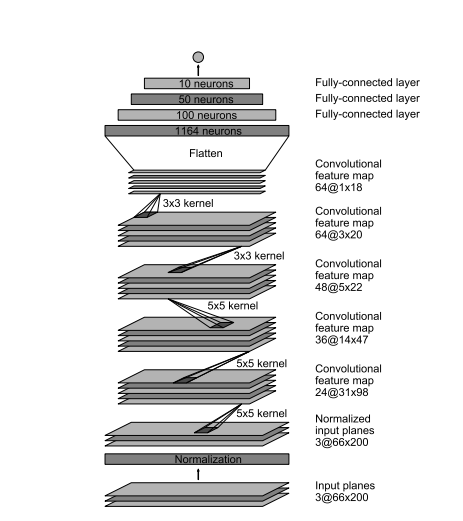

In [40]:
display(IPyImage("img_src/Medium_speedchallenge_architecture.png"))

In [25]:
speed_pred_model = SpeedChallengeModel1()
print(speed_pred_model)

SpeedChallengeModel1(
  (conv2d_0): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2d_1): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2d_2): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2d_3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu): ELU(alpha=1.0)
  (dropout_layer): Dropout2d(p=0.5, inplace=False)
  (flatten_layer): Flatten()
  (linear0): Linear(in_features=1164, out_features=100, bias=True)
  (linear1): Linear(in_features=100, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)


In [42]:
"""
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}



# Load the Data

# Set train and valid directory paths
train_directory = 'train'
valid_directory = 'test'

# Batch size
bs = 32

# Number of classes
num_classes = 10

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = DataLoader(data['test'], batch_size=bs, shuffle=True)

# Print the train, validation and test set data sizes
train_data_size, valid_data_size, test_data_size



# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())


""";

In [43]:
"""
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
     
    # Set to training mode
    model.train()
     
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    for i, (inputs, labels) in enumerate(train_data_loader):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        # Clean existing gradients
        optimizer.zero_grad()
         
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
         
        # Compute loss
        loss = loss_criterion(outputs, labels)
         
        # Backpropagate the gradients
        loss.backward()
         
        # Update the parameters
        optimizer.step()
         
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
         
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
         
        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        
        
        
        
        
        # Validation - No gradient tracking needed
with torch.no_grad():
 
    # Set to evaluation mode
    model.eval()
 
    # Validation loop
    for j, (inputs, labels) in enumerate(valid_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
 
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
 
        # Compute loss
        loss = loss_criterion(outputs, labels)
 
        # Compute the total loss for the batch and add it to valid_loss
        valid_loss += loss.item() * inputs.size(0)
 
        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
 
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
        # Compute total accuracy in the whole batch and add to valid_acc
        valid_acc += acc.item() * inputs.size(0)
 
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
     
# Find average training loss and training accuracy
avg_train_loss = train_loss/train_data_size
avg_train_acc = train_acc/float(train_data_size)
 
# Find average training loss and training accuracy
avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/float(valid_data_size)
 
history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
         
epoch_end = time.time()
 
print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        
""";

In [44]:
"""
resnet50 = resnet50.to('cuda:0')
"""

torch.cuda.current_device()

0

In [45]:
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

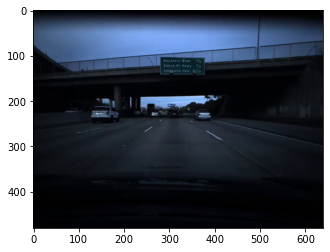

In [57]:
img = mpimg.imread("clean_data/train_imgs/frame0.jpg")
plt.imshow(img)

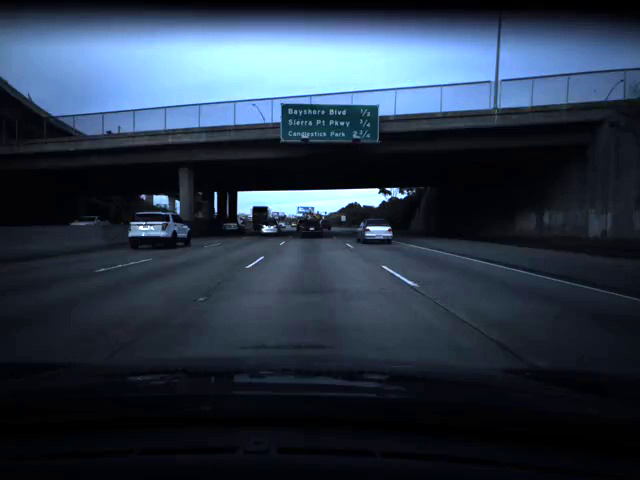

In [68]:
torchvision.transforms.functional.adjust_brightness(Image.fromarray(img),0.7+np.random.uniform())